In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

#### _The AUTOML based generic framework for the AbInbev TURNOVER projects_ ####

In [58]:
## importing the relevant packages:

# clear the workspace
%reset -f

# print list of files in directory
import os
print(os.listdir())

# print/display all plots inline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# the base packages
import collections # for the Counter function
import csv # for reading/writing csv files
import pandas as pd, numpy as np, time, gc, bisect, re
from datetime import datetime as dt

# the various packages/modules used across processing (sklearn), modelling (lightgbm) and bayesian optimization (hyperopt, bayes_opt)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
import sklearn.decomposition as decomposition
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.base import TransformerMixin
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.random_projection as rp
import category_encoders as ce
from sklearn.feature_selection import RFECV, VarianceThreshold
from scipy.stats import truncnorm

from bayes_opt import BayesianOptimization
from tqdm import tqdm
from hyperopt import hp, tpe, STATUS_OK, fmin, Trials, space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

# modelling/clustering algorithms
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# nlp modules
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer

# Evaluation of the model
from sklearn import model_selection
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score

from datetime import timedelta

# Exporting packages for SHAP/LIME
import shap
import lime
import lime.lime_tabular

# missing value imputation
from fancyimpute import KNN, MICE, NuclearNormMinimization

# modules to handle 'if-else' and 'for' loop breaks
import sys
from io import StringIO
from IPython import get_ipython

# pickle modules
import pickle

# define the global variables used later
MAX_EVALS = 3 # number of iterations/parameter sets created towards tuning
N_FOLDS = 5 # number of cv folds
randomseed = 1 # the value for the random state used at various points in the pipeline
pd.options.display.max_rows = 1000 # specify if you want the full output in cells rather the truncated list
pd.options.display.max_columns = 200

# to display multiple outputs in a cell without usin print/display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

['.ipynb_checkpoints', 'april_17.csv', 'aug_16.csv', 'aug_17.csv', 'automl_new.ipynb', 'dec_16.csv', 'fasttext example.ipynb', 'feb_17.csv', 'I3_LighGBM_plus_Lime - Reduced Factors-v4.ipynb', 'jan_17.csv', 'july_16.csv', 'july_17.csv', 'JUNE18_TURNOVER.xlsx', 'june_16.csv', 'june_17.csv', 'MAIN_new.ipynb', 'mar_17.csv', 'may_17.csv', 'NEW.rar', 'nov_16.csv', 'nov_17.csv', 'oct_16.csv', 'oct_17.csv', 'plot_document_classification_20newsgroups.ipynb', 'sep_16.csv', 'sep_17.csv', 'test.txt', 'TRAIN.csv', 'train.txt', 'Turnover Report NAZ 2017 Year End.csv', 'turnover-2016-final.csv', 'VALID.csv']


#### Prepare the train and validation dataset with the labels

- The turnover files ('16 and '17)
    - returns turnover dataframe with leavers and their termination date
    - returns the unique list of leavers
- The raw ads files (from June16 to Dec17 monthly files)
    - all of them are aggregated
    - split into two (active/leavers)
    - 6 most recent records of leavers -> label=1
    - 2 random records of active + leavers (records older than last 6) -> label=0

In [59]:
class prepare_ads():
    
    # init function - returns nothing
    def __init__():
        """ this class creates the training dataframes and the labels from the raw monthly datasets """
        return None
    
    # turnover file creation function
    def to_read_all():
        # psg bands to filter
        psg_bands = ['I-A', 'I-B', 'II-A', 'II-B', 'III-A', 'III-B', 'IV-A', 'IV-B', 'IX-A', 'IX-B', 
                     'V-A', 'V-B', 'VI-A', 'VI-B', 'VII-A', 'VII-B', 'VIII-A', 'VIII-B']

        # read in the 2017 turnover file and filter
        to_17=pd.read_csv('Turnover Report NAZ 2017 Year End.csv')
        to_17=to_17[['Global ID', 'Termination Date', 'Name of action type', 'Name of reason for action', 'Pay Scale Group']]
        to_17=to_17.loc[to_17['Name of reason for action'] == 'Resignation - Personal reason'].reset_index(drop=True)
        to_17=to_17[to_17['Pay Scale Group'].isin(psg_bands)]
        to_17['Termination Date'] = pd.to_datetime(to_17['Termination Date'])
        to_17['term_year'] = to_17['Termination Date'].dt.year
        to_17['term_month'] = to_17['Termination Date'].dt.month_name()
        to_17['term_monthid'] = to_17['Termination Date'].dt.month

        # read in the 2016 turnover file and filter
        to_16=pd.read_csv('turnover-2016-final.csv')
        to_16=to_16[['Global ID', 'Termination Date', 'Name of action type', 'Name of reason for action', 'Pay Scale Group']]
        to_16=to_16.loc[to_16['Name of reason for action'] == 'Resignation - Personal reason'].reset_index(drop=True)
        to_16=to_16[to_16['Pay Scale Group'].isin(psg_bands)]
        to_16['Termination Date'] = pd.to_datetime(to_16['Termination Date'])
        to_16['term_year'] = to_16['Termination Date'].dt.year
        to_16['term_month'] = to_16['Termination Date'].dt.month_name()
        to_16['term_monthid'] = to_16['Termination Date'].dt.month
        to_16=to_16.loc[to_16['term_monthid'] > 5].reset_index(drop=True)

        # append the two sets of people
        to_all = pd.concat([to_16.reset_index(drop=True), to_17], axis=0)
        to_all.drop_duplicates(inplace=True)
        to_all.sort_values(inplace=True, by=['Global ID', 'term_year'])
        to_all.reset_index(drop=True, inplace=True)
        to_all.drop_duplicates(inplace=True, subset='Global ID')
        to_ids = to_all['Global ID'].unique()
        return to_all, to_ids

    # final ads creation function to aggregate all the monthly files
    # n = number of random records to be taken from the pool of records with label=0
    # m = number of recent records to be taken from the pool of records of leavers and given label=1
    def read_all(to_ids, n, m):
        ## reading in the multiple month level files and mapping the labels based on the to files
        dataset_files = os.listdir()
        df16 = [x for x in dataset_files if re.search(pattern='_16', string=x)]
        df17 = [x for x in dataset_files if re.search(pattern='_17', string=x)]
        dict16_keys = [s.replace('.csv', '') for s in df16]
        dict17_keys = [s.replace('.csv', '') for s in df17]

        # the dict to store the individual datasets (per year)
        dict16 = {}
        dict17 = {}
        
        # the dictionary for months and month index mapping
        dict_of_months = {'jan': 'January', 'feb': 'February', 'mar': 'March', 'april': 'April', 'may': 'May', 'june': 'June',
                     'july': 'July', 'aug': 'August', 'sep': 'September', 'oct': 'October', 'nov': 'Novembor', 'dec': 'December'}
        dict_of_months_ids = {'jan': 1, 'feb': 2, 'mar': 3, 'april': 4, 'may': 5, 'june': 6,
                         'july': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

        # append the (multiple) datasets into one
        iter=0
        for i in df16:
            dict16[dict16_keys[iter]] = pd.read_csv(str(i))
            dict16[dict16_keys[iter]]['month_file'] = dict16_keys[iter]
            dict16[dict16_keys[iter]]['term_year'] = 2016
            dict16[dict16_keys[iter]]['term_month_temp'] = dict16[dict16_keys[iter]]['month_file'].apply(lambda s:s.split('_')[0])
            dict16[dict16_keys[iter]]['term_month'] = dict16[dict16_keys[iter]]['term_month_temp'].map(dict_of_months)
            dict16[dict16_keys[iter]]['term_monthid'] = dict16[dict16_keys[iter]]['term_month_temp'].map(dict_of_months_ids)
            iter = iter+1

        iter=0
        for i in df17:
            dict17[dict17_keys[iter]] = pd.read_csv(str(i))
            dict17[dict17_keys[iter]]['month_file'] = dict17_keys[iter]
            dict17[dict17_keys[iter]]['term_year'] = 2017
            dict17[dict17_keys[iter]]['term_month_temp'] = dict17[dict17_keys[iter]]['month_file'].apply(lambda s:s.split('_')[0])
            dict17[dict17_keys[iter]]['term_month'] = dict17[dict17_keys[iter]]['term_month_temp'].map(dict_of_months)
            dict17[dict17_keys[iter]]['term_monthid'] = dict17[dict17_keys[iter]]['term_month_temp'].map(dict_of_months_ids)
            iter = iter+1

        df_16 = pd.concat(dict16.values(), ignore_index=True)
        df_17 = pd.concat(dict17.values(), ignore_index=True)

        df_all = pd.concat([df_16.reset_index(drop=True), df_17], axis=0)
        df_all['global id'] = df_all['global id'].astype(int)
        df_all['original id'] = df_all['original id'].astype(int)

        df_all_temp=df_all.copy()
        df_all_temp['flag_1'] = df_all_temp['global id'].isin(to_ids).astype(int)
        df_all_temp['flag_2'] = df_all_temp['original id'].isin(to_ids).astype(int)
        df_all_temp['flag'] = np.where((df_all_temp['flag_1'] == 1) | (df_all_temp['flag_2'] == 1), 1, 0)

        # taking top m=3 recent records of leavers to flag as labels=1
        x=df_all_temp.sort_values(ascending=False, by=['term_year', 'term_monthid']).groupby('global id').head(m)
        # taking only The most recent record of leavers for label=1
        #x=df_all_temp.sort_values(ascending=False, by=['global id', 'term_year', 'term_monthid']).drop_duplicates(['global id'])
        x=x.loc[x['flag'] == 1].reset_index(drop=True)
        x=x[['global id', 'term_year', 'term_monthid', 'flag']].reset_index(drop=True)
        x.rename(columns={'flag': 'label'}, inplace=True)

        df_all.drop(['label'], inplace=True, axis=1)
        df_all_new=pd.merge(df_all, x, how='left', on=['global id', 'term_year', 'term_monthid'])
        df_all_new['label'].fillna(0, inplace=True)
        df_all_new['label'] = df_all_new['label'].astype(int)
        df_all_new['term_monthid'] = df_all_new['term_monthid'].astype(int)
        df_all_new.drop(['month_file', 'term_month_temp', 'term_month'], axis=1, inplace=True)
        df_all_new.sort_values(by=['global id', 'term_year', 'term_monthid'], inplace=True)

        mask = df_all_new['label'] == 1
        df_pos_labels = df_all_new[mask]
        df_neg_labels = df_all_new[~mask]

        df_neg_labels=df_neg_labels.groupby('global id').apply(lambda x: x.sample(n, replace=True)).reset_index(drop=True)
#         df_neg_labels['groupid'] = df_neg_labels.groupby(['global id']).cumcount()+1
#         df_neg_labels['sample_flag'] = np.where((df_neg_labels['groupid'] % n == 0), 1, 0)
#         df_neg_labels = df_neg_labels.loc[df_neg_labels['sample_flag'] == 1].reset_index(drop=True)
#         df_neg_labels.drop(['groupid', 'sample_flag'], axis=1, inplace=True)

        df_all_complete = pd.concat([df_pos_labels.reset_index(drop=True), df_neg_labels], axis=0)
        df_all_complete.drop(['term_year', 'term_monthid'], axis=1, inplace=True)

        df_final = df_all_complete.loc[df_all_complete['global id'].isin(to_ids)]
        df_final.shape

        return df_all_complete
    
    # main function that is called, prepares the datasets, and writes the TRAIN file into the working dir
    # default values for n and m are given (6 recent records of leavers -> label=1, 2 random records of active -> label=0)
    def main(n=1, m=6):
        to_all, to_ids = prepare_ads.to_read_all()
        df_all = prepare_ads.read_all(to_ids, n, m)

        df_all.to_csv('TRAIN.csv', index=False)
        #one-time exercise below so uncomment for the fresh beginning run
        #os.replace('dec_17.csv', 'VALID.csv')
        return None

#### HELPER FUNCTIONS #####
- Append datasets (train/valid)
    - only used in the cases you have multiple train/validation files (for some reason?)
    - appends on the basis of files found in folder starting with the string 'train' and 'valid'
- DateTime feature engineering (year, quarter, season, month, week, day -> their corresponding string/numeric representations)
    - this is done to bring the different representations of the date dimension as features into the model
    - in most contexts where a time-series based approach is not employed, it is still a good practise to represent the date dimension in the form of numerical/categorical features that can help the model find (if any) date level information
- Frequency count of a vector
    - a helper function to get frequency count of different values in a list/vector
- Deviation encoding of categorical features (not part of feature engineering since implemented before encoding)

In [60]:
## HELPER FUNCTIONS CLASS ##

class helper_funcs():
    
    def __init__():
        """ helper functions used across the pipeline """
        return None
    
    ## find and append multiple dataframes of the type specified in string
    def append_datasets(cols_to_remove, string = ['TRAIN', 'VALID']):
        # pass either train or valid as str argument
        temp_files = [name for name in os.listdir() if name.startswith(string)]
        temp_dict = {}
        for i in temp_files:
            df_name = re.sub(string=i, pattern='.csv', repl='')
            print(df_name)
            temp_dict[df_name] = pd.read_csv(i, na_values=['No Data', ' ', 'UNKNOWN', ''])
            temp_dict[df_name].columns = map(str.lower, temp_dict[df_name].columns)
            temp_dict[df_name].drop(cols_to_remove, axis = 1, inplace = True)
            chars_to_remove = [' ', '.', '(', ')', '__', '-']
            for i in chars_to_remove:
                temp_dict[df_name].columns = temp_dict[df_name].columns.str.strip().str.lower().str.replace(i, '_')
        temp_list = [v for k,v in temp_dict.items()]
        temp = pd.concat(temp_list, axis=0, sort=True, ignore_index=True)
        return temp
    
    ## datetime feature engineering
    def datetime_feats(train, valid):
        cols = [s for s in train.columns.values if 'date' in s]
        print('datetime feature engineering is happening ...', '\n')
        # nested function to derive the various datetime features for a given date column
        def dt_feats(df, col):
            df[col] = pd.to_datetime(df[i])
            #df[str(col+'_'+'day')] = df[col].dt.day
            #df[str(col+'_'+'day_name')] = df[col].dt.day_name
            #df[str(col+'_'+'dayofweek')] = df[col].dt.dayofweek
            df[str(col+'_'+'dayofyear')] = df[col].dt.dayofyear
            #df[str(col+'_'+'days_in_month')] = df[col].dt.days_in_month
            df[str(col+'_'+'month')] = df[col].dt.month
            #df[str(col+'_'+'month_name')] = df[col].dt.month_name
            df[str(col+'_'+'quarter')] = df[col].dt.quarter
            #df[str(col+'_'+'week')] = df[col].dt.week
            #df[str(col+'_'+'weekday')] = df[col].dt.weekday
            df[str(col+'_'+'year')] = df[col].dt.year
            #df[col] = df[col].dt.date
            df = df.drop([col], axis = 1)
            return df
        # loop function over all raw date columns
        for i in cols:
            train = dt_feats(train, i)
            valid = dt_feats(valid, i)
        return train, valid
    
    ## function to get frequency count of elements in a vector/list
    def freq_count(input_vector):
        return collections.Counter(input_vector)
    
    ## function to make deviation encoding features
    def categ_feat_eng(train_df, valid_df, cat_columns):
        print('categorical feature engineering is happening ...', '\n')
        global iter
        iter = 0
        for i in tqdm(cat_columns):
            grouped_df = pd.DataFrame(train_df.groupby([i])['label'].agg(['mean', 'count'])).reset_index()
            grouped_df.rename(columns={'mean': str('mean_' + cat_columns[iter]),
                                       'count': str('count_' + cat_columns[iter])}, inplace=True)
            train_df = pd.merge(train_df, grouped_df, how='left')
            valid_df = pd.merge(valid_df, grouped_df, how='left')
            iter += 1
        return train_df, valid_df

#### LOOP BREAK FUNCTION ####

*To allow early exit of loops or conditional statements to handle exceptions/errors*

In [61]:
""" Allows exit() to work if script is invoked with IPython without raising NameError Exception. Keeps kernel alive. """

class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup

def ipy_exit():
    raise IpyExit

if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

' Allows exit() to work if script is invoked with IPython without raising NameError Exception. Keeps kernel alive. '

#### The Missing value imputation class ####

- implements multiple methods to perform missing value treatement
- simple methods (mean/median/mode) imputation for categorical and numerical features.
    - slightly tweak for adding grouped level if needed
    - currently built to perform imputation consistent to below process (after encoding)
- fancy methods (NNM/KNN/MICE) imputation for numerical features only
    - requires encoding to be done prior

In [62]:
## MISSING VALUE IMPUTATION CLASS ##

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with mean of column.
        """
        
    def fit(self, X, y=None):
#         X.groupby(['pay_scale_group', 'abinbev_entity2'])
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], 
                              index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
    def num_missing(self):
        return sum(self.isnull())
    
    def imputer_method(self, column, method=['mean', 'median', 'most_frequent']):
        x = Imputer(missing_values = 'NaN', strategy = method, axis = 0)
        return x.fit_transform(self[[column]]).ravel()
    
    def fancy_impute(X, which_method):
        """ currently supported algorithms are KNN, NNM and MICE from the fancyimpute package
        which_method = ['KNN', 'NNM', 'MICE']
        """
        print(which_method, ' based missing value imputation is happening ...', '\n')
        
        if which_method == 'NNM': X = NuclearNormMinimization().complete(X) # NNM method
        if which_method == 'KNN': X = KNN(k=3, verbose=False).complete(X) # KNN method
        if which_method == 'MICE':
            X_complete_df = X.copy()
            mice = MICE(verbose=False)
            X_complete = mice.complete(np.asarray(X.values, dtype=float))
            X_complete_df.loc[:, X.columns] = X_complete[:][:]
            X = X_complete_df
        print('missing value imputation completed', '\n')
        return X

#### ENCODING CLASS ####
- various types of encoding here
    - label encoder
    - binary encoder
    - base encoder
    - hashing encoder
    - ordinal encoder (similar to label, different implementation)
    - one-hot encoder

In [63]:
## ENCODERS CLASS ##

class categ_encoders():
    
    def encoding(train, valid, y_train, y_valid, which=['le', 'be', 'bne', 'ohe', 'he', 'oe']):
        if which=='le':
            train, valid, categorical_names = categ_encoders.labelEncoder(train, valid)
        elif which in ['be', 'bne', 'ohe', 'he', 'oe']:
            train, valid, categorical_names = categ_encoders.ce_encodings(train, valid, y_train, y_valid, which)
        else :
            print('Not supported. Use one of [be, bne, he, oe, ohe]', '\n')
            exit()            
        return train, valid, categorical_names
        
    def labelEncoder(train_df, valid_df):
        print('label encoding is happening ...', '\n')
        cat_columns = train_df.select_dtypes(include=['object']).columns.values
        categorical_names = {}
        for feature in tqdm(cat_columns):
            le = preprocessing.LabelEncoder()
            le.fit(train_df[feature].astype(str))
            train_df[feature] = le.transform(train_df[feature].astype(str))
            valid_df[feature] = valid_df[feature].map(lambda i: 'No Data' if i not in le.classes_ else i)
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, 'No Data')
            le.classes_ = le_classes
            valid_df[feature] = le.transform(valid_df[feature].astype(str))
            categorical_names[feature] = le.classes_
        print('label encoding completed', '\n')
        return train_df, valid_df, categorical_names
        
    def ce_encodings(train_df, valid_df, y_train, y_valid, encoding):
        print(str(encoding) + ' encoding is happening ...', '\n')
        if encoding=='bne':    
            enc=ce.BaseNEncoder(base=4)
        elif encoding=='be':
            enc=ce.BinaryEncoder()
        elif encoding=='he':
            enc=ce.HashingEncoder(drop_invariant=True)
        elif encoding=='oe':
            enc=ce.OrdinalEncoder()
        elif encoding=='ohe':
            enc=ce.BaseNEncoder(base=1)
        enc.fit(train_df)
        train_enc=enc.transform(train_df)
        valid_enc=enc.transform(valid_df)
        print('category encoding completed', '\n')
        categorical_names = {}
        return train_enc, valid_enc, categorical_names

#### FEATURE ENGINEERING MODULE ####

- Decomposition features
    - PCA
    - ICA
    - TSVD
    - GRP
    - SRP
    - ...
- Clustering output feaatures
    - KMeans
    - ...
- Deterministic features
    - Binning
    - ...

In [64]:
class feat_eng(object):
    
    def __init__(self):
        """ this module contains several functions for creating new features. find below a brief description of each """
    
    def scalers(self, train, valid, which_method):
        if which_method == 'ss':
            sc = StandardScaler()
            sc.fit(train)
            train_new = pd.DataFrame(sc.transform(train), columns=train.columns.values)
            valid_new = pd.DataFrame(sc.transform(valid), columns=valid.columns.values)
            return train_new, valid_new # scale all variables to zero mean and unit variance, required for PCA and related
        if which_method == 'mm':
            mm = MinMaxScaler()
            mm.fit(train)
            train_new = pd.DataFrame(mm.transform(train), columns=train.columns.values)
            valid_new = pd.DataFrame(mm.transform(valid), columns=valid.columns.values)
            return train_new, valid_new # use this method to iterate
    
    def decomp_various(self, train, valid, n, which_method):
        global decomp_dfs
        decomp_dfs = {}
        decomp_methods = ['PCA', 'FastICA', 'TruncatedSVD', 'GaussianRandomProjection', 'SparseRandomProjection']
        
        for i in decomp_methods:
            if i == 'PCA':
                decomp_obj = getattr(decomposition, i)
                decomp_obj = decomp_obj(n_components=n)
            elif i in ['FastICA', 'TruncatedSVD']:
                decomp_obj = getattr(decomposition, i)
                decomp_obj = decomp_obj(n_components=n)
            else :
                decomp_obj = getattr(rp, i)
                decomp_obj = decomp_obj(n_components=n, eps=0.3)
            
            # perform the multiple decomposition techniques
            train, valid = feat_eng.scalers(self, train, valid, which_method)

            decomp_obj.fit(train)
            decomp_train = pd.DataFrame(decomp_obj.transform(train))
            decomp_valid = pd.DataFrame(decomp_obj.transform(valid))
            cols = list(set(list(decomp_train)))
            cols = [str(i) + '_' + str(s) for s in cols]
            decomp_train.columns = cols
            decomp_valid.columns = cols

            decomp_dfs[i + '_train'] = decomp_train
            decomp_dfs[i + '_valid'] = decomp_valid
            
        feat_eng.df = decomp_dfs
        return None
        
    def return_combined(self, train, valid):        
        for i in list(self.df.keys()):
            if bool(re.search('train', i)):
                train = pd.concat([train.reset_index(drop=True), self.df[i]], axis=1)
            else :
                valid = pd.concat([valid.reset_index(drop=True), self.df[i]], axis=1)
        return train, valid
    
    def kmeans_clusterer(train_df, valid_df, n):
        clusterer = KMeans(n, random_state=1, init='k-means++')
        # fit the clusterer
        clusterer.fit(train_df)
        train_clusters = clusterer.predict(train_df)
        valid_clusters = clusterer.predict(valid_df)
        return train_clusters, valid_clusters
    
    def kmeans_feats(train_df, valid_df, m=5):
        print('m is ', m, '\n')
        for i in range(2, m):
            t, v = feat_eng.kmeans_clusterer(train_df, valid_df, n=i)
            col_name = str('kmeans_'+ str(i))
            t = pd.DataFrame({col_name: t})
            v = pd.DataFrame({col_name: v})
            train_df = pd.concat([train_df.reset_index(drop=True), t], axis=1)
            valid_df = pd.concat([valid_df.reset_index(drop=True), v], axis=1)
        return train_df, valid_df
        

#### FEATURE SELECTION ####
- near zero variance columns are removed (threshold=0.1)
- rf based rfecv with depth=7, column_sampling=0.25, estimators=100 (optional=True/False)

In [65]:
## FEATURE SELECTION

class feat_selection():
    
    def __init__():
        """ this module is for dynamic feature selection after all the processing and feat engineering phases. ideally this
        module is followed by the modelling phase immediately """

    # removing near zero variance columns
    def variance_threshold_selector(train, valid, threshold):
        print('input data shape is: ', train.shape, '\n')
        selector = VarianceThreshold(threshold)
        selector.fit(train)
        X = train[train.columns[selector.get_support(indices=True)]]
        Y = valid[valid.columns[selector.get_support(indices=True)]]
        #display(pd.DataFrame(X.head(5)))
        print('output data shape is: ', X.shape, '\n')
        return X, Y

    # using RFECV
    def rfecv(train, valid, y_train):
        # Create the RFE object and compute a cross-validated score.
        model = LogisticRegression(C=0.1, penalty='l1')
        #model = RandomForestClassifier(max_depth=10, max_features=0.3, n_estimators=200, n_jobs=-1)
        rfecv = RFECV(estimator=model, step=1, scoring='roc_auc', verbose=True)
        rfecv.fit(train, y_train)
        print("Optimal number of features : %d" % rfecv.n_features_, '\n')

        # Plot number of features VS. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (roc-auc)")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()

        features = [f for f,s in zip(train.columns, rfecv.support_) if s]
        train = train[features]
        valid = valid[features]
        return train, valid
    
    def feat_selection(train, valid, y_train, t=0.3):
        # read in the train, valid and y_train objects
        X, Y = feat_selection.variance_threshold_selector(train, valid, threshold=t)
        X, Y = feat_selection.rfecv(train=X, valid=Y, y_train=y_train)
        return X, Y

#### SAMPLING ####
- Oversampling (ADASYN, SMOTE)
- Undersampling (ENN, RENN, AllKNN)
- Oversampling and then Undersampling (SMOTE and ENN/TOMEK)

*it's okay if you have no idea what the above mean. the only thing that is important is to understand why over/undersampling
is done and why or what ratio between*
    - why over/under sampling is done in a classification context
    - what ratio between the 2 classes is important to You in your context
    - how much information loss (or gain) are you willing to tolerate? (create More data than what you have at hand?)

In [66]:
""" Explicitly doing sampling. Use with care if going ahead with the CV based approach. Keep ratio low if so (recommended)

oversampling the minority class using techniques from SMOTE (for oversampling) and ENN/Tomek (for undersampling/cleaning)
ENN worked out better than Tomek
added support for undersampling with ENN/RENN/AllKNN """

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours

def sampler(X_train, y_train, which='smote_enn', frac=0.75):
    """ which = ['adasyn', smote_tomek', 'smote_enn', 'enn', 'renn', 'allknn'] """
    
    feat_names = X_train.columns.values
    
    ### OVERSAMPLING (ADASYN) ###
    if which=='adasyn':
        # Apply ADASYN
        ada = ADASYN(random_state=0)
        X_train, y_train = ada.fit_sample(X_train, y_train)

    ### OVERSAMPLING (SMOTE) AND THEN UNDERSAMPLING (ENN/Tomek) ###
    if which=='smote_tomek':
        # Apply SMOTE + Tomek links
        sm = SMOTETomek(random_state=0, ratio=frac)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    if which=='smote_enn':
        # Apply SMOTE + ENN
        smote_enn = SMOTEENN(random_state=0, ratio=frac)
        X_train, y_train = smote_enn.fit_sample(X_train, y_train)

    ### UNDERSAMPLING (ENN/RENN/AllKNN) ###
    if which=='enn':
        # Apply ENN
        enn = EditedNearestNeighbours(random_state=0)
        X_train, y_train = enn.fit_sample(X_train, y_train)
    if which=='renn':
        # Apply RENN
        renn = RepeatedEditedNearestNeighbours(random_state=0)
        X_train, y_train = renn.fit_sample(X_train, y_train)
    if which=='allknn':
        # Apply AllKNN
        allknn = AllKNN(random_state=0)
        X_train, y_train = allknn.fit_sample(X_train, y_train)

    X_train = pd.DataFrame(data=X_train,columns=feat_names)
    print(X_train.shape, y_train.shape, collections.Counter(y_train))
    
    return X_train, y_train

' Explicitly doing sampling. Use with care if going ahead with the CV based approach. Keep ratio low if so (recommended)\n\noversampling the minority class using techniques from SMOTE (for oversampling) and ENN/Tomek (for undersampling/cleaning)\nENN worked out better than Tomek\nadded support for undersampling with ENN/RENN/AllKNN '

#### h2o AUTOML ####
- automated ML framework by H2O
- https://www.h2o.ai/products/h2o/
- tuning performed for the sampling parameters as well as whether to balance classes post sampling

In [67]:
## h2o AUTO_ML grid search framework
import h2o
from h2o.automl import H2OAutoML

class h2o_automl():
    
    def __init__():
        """ module to invoke h2o auto ml and tune on the sampling parameters. 
        will need to incorporate to super pipeline later """
        
    def automl(os, us, bc, iter, response='response'):
        # initializing the h2o cluster
        h2o.init()
        # Import a sample binary outcome train/test set into H2O
        h2o_train = h2o.import_file(str(str(iter) + '_t_h2o.csv'), header=1)
        h2o_valid = h2o.import_file(str(str(iter) + '_v_h2o.csv'), header=1)
        # Identify the response and set of predictors
        x = list(h2o_train.columns)  #if x is defined as all columns except the response, then x is not required
        x.remove(response)
        # For binary classification, response should be a factor
        h2o_train[response] = h2o_train[response].asfactor()
        h2o_valid[response] = h2o_valid[response].asfactor()

        randomseed = 1
        aml = H2OAutoML(max_runtime_secs = 60, stopping_metric='mean_per_class_error', sort_metric='mean_per_class_error',
                        class_sampling_factors=[os, us], balance_classes = bc)
        aml.train(y = 'response', training_frame = h2o_train)
        
        # Print Leaderboard (ranked by xval metrics)
        print(aml.leaderboard)
        # Evaluate performance on a test set
        perf = aml.leader.model_performance(h2o_valid)
        print('The validation performance (auc) is ', perf.auc())
        return aml, h2o_valid
        
    def get_score(aml, h2o_valid, y_valid, threshold = 0.1):
        pred2 = aml.predict(h2o_valid)[:,2]
        pred = pred2.as_data_frame().as_matrix()
        predict = np.where(pred > threshold, 1, 0)
        y_test=y_valid

        recall_score = sklearn.metrics.recall_score(y_pred=predict, y_true=y_test)
        precision_score = sklearn.metrics.precision_score(y_pred=predict, y_true=y_test)
        f1_score = sklearn.metrics.f1_score(y_pred=predict, y_true=y_test)
        auc_score = roc_auc_score(y_test, pred)
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test).ravel()
        print(sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test), '\n')
        print('recall score is: ', recall_score)
        print('precision score is: ', precision_score)
        print('f1_score is: ', f1_score)
        print('accuracy score: ', sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predict))
        print('The final AUC after taking the best params and num_rounds when it stopped is {:.4f}.'.format(auc_score), '\n')
        
        return pred2, predict, auc_score

#### MOTHER OF ALL PIPELINES ####
- hyperopt based
- the process flow is as below
    - prepare data
    - pre-processing
        - missing value imputation
        - categorical encoding
    - feature engineering
    - feature selection
    - automl (modelling pipeline)

In [76]:
## MOTHER OF ALL PIPELINES ##
# hyperopt based ##

class main(object):
    
    def __init__(self):
        """ random """
        return None    
    
    def prepare(self, cols_to_remove, response='label'):
        """ checks first if backup pickles exist in folder already. 
        if so skips the major computation segment that is already back up """
        
        pickle_files = [x for x in os.listdir() if re.search(pattern='.pickle', string=x)]
        trials = {'backup_1': None}
        
        if len(pickle_files) > 0 :
            # opening the first pickle only for now (will later add a loop for all the pickle files)
            
            print('backups available...hence using them stead of reinventing the wheel \n')
            f = open(pickle_files[0], "rb")
            train = pickle.load(f)
            valid = pickle.load(f)
            y_train = pickle.load(f)
            y_valid = pickle.load(f)
            backup_md = pickle.load(f)
            f.close()
            print(backup_md)
            
            trials['backup_1'] = main.backup_optimize(train=train, valid=valid, y_train=y_train, 
                                                      y_valid=y_valid, backup_md=backup_md)
        
        else :
            # read in the train and validation datasets
            # clean column names and remove unwanted columns
            # append the (multiple?) train datasets into a single one (simple appending for now)

            print('1. Appending the multiple train/valid datasets in the working directory \n')
            train = helper_funcs.append_datasets(string='TRAIN', cols_to_remove=cols_to_remove)
            valid = helper_funcs.append_datasets(string='VALID', cols_to_remove=cols_to_remove)
            main.removed_cols = cols_to_remove ## attribute

            # creating the datetime features from date columns (works only for cols with date in header, modify for other cases)
            print('2. Datetime features are being created for the columns (which have "date" in their column name) \n')
            train, valid = helper_funcs.datetime_feats(train, valid)

            # missing value threshold control (for both rows and columns)
            mt = 0.6
            print(train.shape, '\n')
            train.dropna(thresh=mt*(train.shape[0]), axis=1, inplace = True)
            train.dropna(thresh=mt*(train.shape[1]), axis=0, inplace = True)
            print(train.shape, '\n')
            valid = valid[train.columns]
            valid.dropna(thresh=mt*(valid.shape[0]), axis=1, inplace = True)
            train = train[valid.columns]
            main.missing_threshold = mt ## attribute

            # reset the index since inplace operations happened earlier
            train.index = pd.RangeIndex(len(train.index))
            valid.index = pd.RangeIndex(len(valid.index))
            # save the global ids for mapping later (forward looking)
            valid_ids = valid[['original_id', response]]
            main.validation_labels = valid_ids ## attribute
            valid_ids.to_csv('test_dfs.csv', index=False)
            valid.drop('original_id', axis=1, inplace=True)
            train.drop('original_id', axis=1, inplace=True)
            X_train = pd.DataFrame(train)
            X_valid = pd.DataFrame(valid)
            # the class balance in the training dataset for the response
            print(helper_funcs.freq_count(X_train[response]), '\n')
            # creating the response vector
            y_train = X_train[response].values
            y_valid = X_valid[response].values

            # categorical columns (names, indices and dtypes)
            x = list(X_train.dtypes)
            x_1 = [1 if x == 'O' else 0 for x in x]
            categorical_idx = [i for i, x in enumerate(x_1) if x == 1]
            # Get feature names and their values for categorical data (needed for LIME)
            cat_columns = X_train.select_dtypes(include=['object']).columns.values
            X_train, X_valid = helper_funcs.categ_feat_eng(X_train, X_valid, cat_columns)

            # drop the response
            X_train = X_train.drop([response], axis = 1)
            X_valid = X_valid.drop([response], axis = 1)

            # call the main optimize function that does the whole tuning (inside the nested score function)
            trials = main.optimize(train=X_train, valid=X_valid, y_train=y_train, y_valid=y_valid)
        return trials
    
    # function to be minimized and sent to the optimize function of hyperopt
    def score(params):
        start_time = time.time()
        
        global ITERATION
        ITERATION += 1
        
        train=main.train
        valid=main.valid
        y_train=main.y_train
        y_valid=main.y_valid
        
        print('\n', params, '\n')
        #######################################################################################################
        ## ENCODING ##
        #######################################################################################################
        cat_columns = train.select_dtypes(include=['object']).columns.values
        train_cat = train[cat_columns]
        num_cols = list(set(train.columns)-set(train_cat.columns))
        train_num = train[num_cols]
        valid_cat = valid[cat_columns]
        valid_num = valid[num_cols]
        
        train_cat, valid_cat, categorical_names = categ_encoders.encoding(train_cat, valid_cat, y_train, y_valid,
                                                                            which=params['encoder'])
        train = pd.concat([train_cat.reset_index(drop=True), train_num], axis=1)
        valid = pd.concat([valid_cat.reset_index(drop=True), valid_num], axis=1)
        print('encoding completed ...', '\n')
        main.categorical_dict = categorical_names ## attribute
        #######################################################################################################

        
        #######################################################################################################
        ## CORRELATION ANALYSIS ##
        #######################################################################################################
        # remove highly correlated features to reduce further computation time
        print('correlation analysis is happening ...', '\n')
        # Create correlation matrix
        corr_matrix = train.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        # Find index of feature columns with correlation greater than 0.9
        to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]        
        # Drop features
        #print(to_drop, '\n')
        train.drop(to_drop, axis=1, inplace=True)
        valid.drop(to_drop, axis=1, inplace=True)
        print('correlation analysis completed ...', '\n')
        main.cor_dropped_vars = to_drop ## attribute
        #######################################################################################################
    
        
        #######################################################################################################
        ## MISSING VALUE IMPUTATION ##
        #######################################################################################################
        # store all feature names
        feat_names = train.columns.values
        feat_names2 = valid.columns.values
        
        if params['miss_treatment'] == 'simple':
            miss_enc = DataFrameImputer()
            miss_enc.fit(X=train)
            train_new = miss_enc.transform(train)
            valid_new = miss_enc.transform(valid)
        elif params['miss_treatment'] in ['KNN', 'MICE']:
            train_new = DataFrameImputer.fancy_impute(train, which_method=params['miss_treatment'])
            valid_new = DataFrameImputer.fancy_impute(valid, which_method=params['miss_treatment'])

        # returning as pandas dataframes to retain feature names for LIME and feature importance plots
        train = pd.DataFrame(data=train_new, columns=feat_names)
        valid = pd.DataFrame(data=valid_new, columns=feat_names2)
        print('missing value treatment completed ...', '\n')
        #######################################################################################################
        

        #######################################################################################################
        ## STATUS REPORT ##
        #######################################################################################################
        print('STATUS REPORT \n')
        print(train.shape)
        print(valid.shape)
        print(y_train.shape)
        print(y_valid.shape)
        print(collections.Counter(y_train))
        print(collections.Counter(y_valid))
        #######################################################################################################
        
        #######################################################################################################
        ## FEATURE ENGINEERING ##
        #######################################################################################################
        """ the feature engineering module 
            - 1. PCA/ICA/TSVD/GRP/SRP
            - 2. KMEANS """
        
        ## 1.
        feat_eng_instance = feat_eng()
        feat_eng_instance.decomp_various(train, valid, n=int(params['decomp_feats']), which_method=params['scaler'])
        train, valid = feat_eng_instance.return_combined(train, valid)
        
        ## 2.
        train, valid = feat_eng.kmeans_feats(train_df=train, valid_df=valid, m=int(params['kmeans_n']))
        #######################################################################################################
        
        
        #######################################################################################################
        ## FEATURE SELECTION ##
        #######################################################################################################
        train, valid = feat_selection.variance_threshold_selector(train=train, valid=valid, threshold=0.1)
        
        if params['feat_selection'] == 'true':
            train, valid = feat_selection.rfecv(train=train, valid=valid, y_train=y_train)
        #######################################################################################################
        
        
        #######################################################################################################
        ## SAMPLING ##
        #######################################################################################################
        """ oversampling or undersampling or oversampling with undersampling """
        
        if params['sampler']['choice'] == 'yes':
            train, y_train = sampler(X_train=train, y_train=y_train, 
                                     which=params['sampler']['which_method'], 
                                     frac=params['sampler']['frac'])
        else :
            print('no sampling done in this pipeline', '\n')
        #######################################################################################################
        
        
        #######################################################################################################
        ## BACKUP ##
        #######################################################################################################
        backup = str(str(ITERATION) + str(dt.now().strftime('_%H_%M_%d_%m_%Y.pickle')))
        f = open(backup, "wb")
        pickle.dump(train, f)
        pickle.dump(valid, f)
        pickle.dump(y_train, f)
        pickle.dump(y_valid, f)
        
        backup_md = {'params': params, 'pickle_name': backup, 'randomseed': randomseed}
        pickle.dump(backup_md, f)
        
        f.close()
        #######################################################################################################
        
        
        #######################################################################################################
        ## SAVE AS FLATFILES ##
        #######################################################################################################
        train['response'] = y_train
        valid['response'] = y_valid

        train.to_csv(str(str(ITERATION) + '_t_h2o.csv'), index=False)
        valid.to_csv(str(str(ITERATION) + '_v_h2o.csv'), index=False)
        #######################################################################################################
        
        
        #######################################################################################################
        ## H2O AUTOML ##
        #######################################################################################################
        h2o_os = params['h2o_automl_params']['oversampling']
        h2o_us = params['h2o_automl_params']['undersampling']
        h2o_bc = params['h2o_automl_params']['balance_classes']
        
        aml, h2o_valid = h2o_automl.automl(os=h2o_os, bc=h2o_bc, us=h2o_us, iter=ITERATION)
        
        pred, predict, score = h2o_automl.get_score(aml=aml, h2o_valid=h2o_valid, y_valid=y_valid,
                                                    threshold=aml.leader.find_threshold_by_max_metric('min_per_class_accuracy'))
        
        setattr(main, str('aml_' + str(ITERATION)), aml)
        setattr(main, str('pred_' + str(ITERATION)), pred)
        setattr(main, str('predict_' + str(ITERATION)), predict)
        setattr(main, str('score_' + str(ITERATION)), score)
        setattr(main, str('threshold_' + str(ITERATION)), aml.leader.find_threshold_by_max_metric('min_per_class_accuracy'))
        setattr(main, str('h2o_valid_' + str(ITERATION)), h2o_valid)
        #######################################################################################################
        
        loss = 1 - score
        end_time = time.time()
        time_taken = timedelta(seconds = round(end_time - start_time))
        print("Execution took: %s secs (Wall clock time)" % time_taken)

        return {'loss': loss, 'status': STATUS_OK, 'params': params, 'auc': score, 'eval_time': time_taken}
    
    # function to do hyperparameter tuning with hyperopt (bayesian based method)
    def optimize(train, valid, y_train, y_valid):
                
        main.train = train
        main.valid = valid
        main.y_train = y_train
        main.y_valid= y_valid        
        
        # Keep track of evals
        global ITERATION
        ITERATION = 0
        global trials
        trials = Trials()
        
        # space to be traversed for the hyperopt function
        space = {
            'encoder': hp.choice('encoder', ['he', 'le']),
            'eval_time': time.time(),
            'miss_treatment': hp.choice('missing', ['simple']),
            'decomp_feats': hp.quniform('n', 2, 10, 1),
            'scaler': hp.choice('scaler', ['ss', 'mm']),
            'kmeans_n': hp.quniform('m', 2, 5, 1),
            'feat_selection': hp.choice('rfecv', ['false', 'false']),
            'sampler': hp.choice('sampler', [
                {
                    'choice': 'no',
                    'which_method': hp.choice('sampling', ['smote_enn']),
                    'frac': hp.quniform('frac', 0.85, 1, 0.05)
                },
                {
                    'choice': 'no'
                }
            ]),
            'h2o_automl_params': hp.choice('sampling_params', [
                {
                    'undersampling': hp.uniform('us', 0.1, 1),
                    'oversampling': hp.uniform('os', 2, 5),
                    'balance_classes': hp.choice('bc', ['False', 'False'])
                }
            ])
        }
        
        best = fmin(main.score, space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS,
                    rstate=np.random.RandomState(randomseed))
        best = trials.best_trial['result']['params']
        
        main.best = space_eval(space, trials.argmin)
        main.trials = trials
        
        return trials # results of all the iterations, the best params
    
    def backup_optimize(train, valid, y_train, y_valid, backup_md):
        main.train = train
        main.valid = valid
        main.y_train = y_train
        main.y_valid= y_valid
        main.md = backup_md
        params = backup_md['params']
        
        # Keep track of evals
        global ITERATION
        ITERATION = backup_md['pickle_name'][0]
        
        #######################################################################################################
        ## SAVE AS FLATFILES ##
        #######################################################################################################
        train['response'] = y_train
        valid['response'] = y_valid

        train.to_csv(str(str(ITERATION) + '_t_h2o.csv'), index=False)
        valid.to_csv(str(str(ITERATION) + '_v_h2o.csv'), index=False)
        #######################################################################################################
        
        
        #######################################################################################################
        ## H2O AUTOML ##
        #######################################################################################################
        h2o_os = params['h2o_automl_params']['oversampling']
        h2o_us = params['h2o_automl_params']['undersampling']
        h2o_bc = params['h2o_automl_params']['balance_classes']
        
        aml, h2o_valid = h2o_automl.automl(os=h2o_os, bc=h2o_bc, us=h2o_us, iter=ITERATION)
        
        pred, predict, score = h2o_automl.get_score(aml=aml, h2o_valid=h2o_valid, y_valid=y_valid,
                                                    threshold=aml.leader.find_threshold_by_max_metric('min_per_class_accuracy'))
        
        setattr(main, str('aml_' + str(ITERATION)), aml)
        setattr(main, str('pred_' + str(ITERATION)), pred)
        setattr(main, str('predict_' + str(ITERATION)), predict)
        setattr(main, str('score_' + str(ITERATION)), score)
        setattr(main, str('threshold_' + str(ITERATION)), aml.leader.find_threshold_by_max_metric('min_per_class_accuracy'))
        setattr(main, str('h2o_valid_' + str(ITERATION)), h2o_valid)
        #######################################################################################################
        trials = score
        
        return trials        

In [69]:
prepare_ads.main()

In [77]:
x=main()

In [78]:
trials = x.prepare(cols_to_remove=['global id', 'manager global id', 'personnel number manager', 
                                                  'short text of organizational unit', 'position text', 
                                                  'physical work location-description', 'manager position desc', 
                                   'costcenter description', 'local entity description', 'appraiser id'])

1. Appending the multiple train/valid datasets in the working directory 

TRAIN
VALID
2. Datetime features are being created for the columns (which have "date" in their column name) 

datetime feature engineering is happening ... 

(12429, 101) 

(11362, 67) 

Counter({0: 6824, 1: 4538}) 

categorical feature engineering is happening ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.83it/s]



 {'decomp_feats': 7.0, 'encoder': 'he', 'eval_time': 1540452110.239333, 'feat_selection': 'false', 'h2o_automl_params': {'balance_classes': 'False', 'oversampling': 2.701652699333679, 'undersampling': 0.315595564665503}, 'kmeans_n': 4.0, 'miss_treatment': 'simple', 'sampler': {'choice': 'no', 'frac': 0.9, 'which_method': 'smote_enn'}, 'scaler': 'ss'} 

he encoding is happening ... 

category encoding completed 

encoding completed ... 

correlation analysis is happening ... 

correlation analysis completed ... 

missing value treatment completed ... 

STATUS REPORT 

(11362, 89)
(5734, 89)
(11362,)
(5734,)
Counter({0: 6824, 1: 4538})
Counter({0: 5453, 1: 281})
m is  4 

input data shape is:  (11362, 126) 

output data shape is:  (11362, 93) 

no sampling done in this pipeline 

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,19 hours 55 mins
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,3 months and 14 days !!!
H2O cluster name:,H2O_from_python_Lenovo_6jriv6
H2O cluster total nodes:,1
H2O cluster free memory:,3.140 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_0_AutoML_20181025_125214,0.950912,0.275046,0.112152,0.285611,0.0815739
StackedEnsemble_AllModels_0_AutoML_20181025_125214,0.950912,0.275046,0.112152,0.285611,0.0815739
DRF_0_AutoML_20181025_125214,0.943767,0.363034,0.117987,0.322979,0.104315
XRT_0_AutoML_20181025_125214,0.941892,0.368168,0.123851,0.324091,0.105035
GBM_grid_0_AutoML_20181025_125214_model_0,0.924979,0.357887,0.146588,0.333298,0.111088
GLM_grid_0_AutoML_20181025_125214_model_0,0.833173,0.485691,0.244199,0.404174,0.163356



The validation performance (auc) is  0.7393468481550199
stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[5252  201]
 [ 199   82]] 

recall score is:  0.2918149466192171
precision score is:  0.28975265017667845
f1_score is:  0.2907801418439716
accuracy score:  0.930240669689571
The final AUC after taking the best params and num_rounds when it stopped is 0.7393. 

Execution took: 0:01:30 secs (Wall clock time)

 {'decomp_feats': 7.0, 'encoder': 'le', 'eval_time': 1540452110.239333, 'feat_selection': 'false', 'h2o_automl_params': {'balance_classes': 'False', 'oversampling': 2.965137127316968, 'undersampling': 0.7323804931999229}, 'kmeans_n': 4.0, 'miss_treatment': 'simple', 'sampler': {'choice': 'no'}, 'scaler': 'mm'} 

label encoding is happening ... 



  0%|                                                                                           | 0/27 [00:00<?, ?it/s]C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

label encoding completed 

encoding completed ... 

correlation analysis is happening ... 

correlation analysis completed ... 

missing value treatment completed ... 

STATUS REPORT 

(11362, 104)
(5734, 104)
(11362,)
(5734,)
Counter({0: 6824, 1: 4538})
Counter({0: 5453, 1: 281})
m is  4 

input data shape is:  (11362, 141) 

output data shape is:  (11362, 110) 

no sampling done in this pipeline 

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,19 hours 56 mins
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,3 months and 14 days !!!
H2O cluster name:,H2O_from_python_Lenovo_6jriv6
H2O cluster total nodes:,1
H2O cluster free memory:,3.073 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_0_AutoML_20181025_125334,0.950518,0.275586,0.114727,0.286299,0.0819671
StackedEnsemble_BestOfFamily_0_AutoML_20181025_125334,0.950518,0.275586,0.114727,0.286299,0.0819671
DRF_0_AutoML_20181025_125334,0.943687,0.36549,0.120346,0.324814,0.105504
XRT_0_AutoML_20181025_125334,0.943048,0.370093,0.126594,0.32873,0.108064
GBM_grid_0_AutoML_20181025_125334_model_0,0.874458,0.483887,0.207944,0.396537,0.157242
GLM_grid_0_AutoML_20181025_125334_model_0,0.841046,0.475734,0.242297,0.399385,0.159509



The validation performance (auc) is  0.7172583833509649
stackedensemble prediction progress: |████████████████████████████████████| 100%
[[5424   29]
 [ 255   26]] 

recall score is:  0.09252669039145907
precision score is:  0.4727272727272727
f1_score is:  0.15476190476190474
accuracy score:  0.9504708754795954
The final AUC after taking the best params and num_rounds when it stopped is 0.7173. 

Execution took: 0:01:20 secs (Wall clock time)

 {'decomp_feats': 6.0, 'encoder': 'he', 'eval_time': 1540452110.239333, 'feat_selection': 'false', 'h2o_automl_params': {'balance_classes': 'False', 'oversampling': 4.288486132803, 'undersampling': 0.7152016958868622}, 'kmeans_n': 3.0, 'miss_treatment': 'simple', 'sampler': {'choice': 'no'}, 'scaler': 'mm'} 

he encoding is happening ... 

category encoding completed 

encoding completed ... 

correlation analysis is happening ... 

correlation analysis completed ... 

missing value treatment completed ... 

STATUS REPORT 

(11362, 89)
(5734, 8

H2O cluster uptime:,19 hours 58 mins
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,3 months and 14 days !!!
H2O cluster name:,H2O_from_python_Lenovo_6jriv6
H2O cluster total nodes:,1
H2O cluster free memory:,3.031 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_0_AutoML_20181025_125503,0.95043,0.27542,0.111152,0.285628,0.0815836
StackedEnsemble_BestOfFamily_0_AutoML_20181025_125503,0.95043,0.27542,0.111152,0.285628,0.0815836
XRT_0_AutoML_20181025_125503,0.941986,0.364149,0.123185,0.325229,0.105774
DRF_0_AutoML_20181025_125503,0.94196,0.362516,0.123897,0.324062,0.105016
GBM_grid_0_AutoML_20181025_125503_model_0,0.927655,0.356135,0.142918,0.331799,0.110091
GLM_grid_0_AutoML_20181025_125503_model_0,0.841437,0.474241,0.236762,0.399462,0.15957



The validation performance (auc) is  0.7088298386796781
stackedensemble prediction progress: |████████████████████████████████████| 100%
[[5300  153]
 [ 221   60]] 

recall score is:  0.21352313167259787
precision score is:  0.28169014084507044
f1_score is:  0.242914979757085
accuracy score:  0.9347750261597488
The final AUC after taking the best params and num_rounds when it stopped is 0.7088. 

Execution took: 0:01:29 secs (Wall clock time)


In [83]:
w1,y1,z1=h2o_automl.get_score(aml=x.aml_1, h2o_valid=x.h2o_valid_1, y_valid=x.y_valid, threshold=0.045)

stackedensemble prediction progress: |████████████████████████████████████| 100%


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[3284 2169]
 [  77  204]] 

recall score is:  0.7259786476868327
precision score is:  0.08596713021491782
f1_score is:  0.15373021853805574
accuracy score:  0.608301360306941
The final AUC after taking the best params and num_rounds when it stopped is 0.7393. 



In [91]:
## NLP Class

class nlp_feats(object):
    
    def __init__(self):
        return None
    
    def prepare(self, train_path = 'TRAIN.csv', test_path = 'VALID.csv'):
        train=pd.read_csv(train_path, na_values=['No Data', ' ', 'UNKNOWN'])
        test=pd.read_csv(test_path, na_values=['No Data', ' ', 'UNKNOWN'])
        text_cols = ['short text of organizational unit', 'position text', 'opr change', 'm_opr change',
                    'physical work location-description', 'physical work location-city',
                    'manager position desc', 'costcenter description', 'global job', 
                    'local entity description', 'pers. subarea text', 'group']
        train_text = train[text_cols]
        test_text = test[text_cols]
        train_text['string_all'] = train_text[text_cols].apply(lambda x: ' '.join(x.dropna()), axis=1)
        test_text['string_all'] = test_text[text_cols].apply(lambda x: ' '.join(x.dropna()), axis=1)
        train_text = train_text[['string_all']]
        test_text = test_text[['string_all']]
        y_train = train[['label']]
        y_test = test[['label']]
        return train_text, test_text, y_train, y_test
    
    def make_feats(self, train_text, test_text):
        # nlp feats

        ## HASHING ##
        # create the transform
        vectorizer = HashingVectorizer(n_features=500, ngram_range=(1,4), stop_words='english',
                                       strip_accents='unicode', analyzer='char', norm='l1')
        vectorizer.fit(train_text)
        train_new1 = pd.DataFrame(vectorizer.transform(train_text.string_all).todense())
        test_new1 = pd.DataFrame(vectorizer.transform(test_text.string_all).todense())

        ## COUNTVECTORIZER ##
        # create the transform
        vectorizer = CountVectorizer(strip_accents='unicode', ngram_range=(1,5), stop_words='english', max_features=100)
        # tokenize and build vocab
        vectorizer.fit(train_text.string_all)
        # summarize
        #print(vectorizer.vocabulary_)
        train_new2 = pd.DataFrame(vectorizer.transform(train_text.string_all).todense(), columns=vectorizer.get_feature_names())
        test_new2 = pd.DataFrame(vectorizer.transform(test_text.string_all).todense(), columns=vectorizer.get_feature_names())

        ## TFIDVECTORIZER ##
        # create the transform
        vectorizer = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,4), stop_words='english', max_features=100)
        # tokenize and build vocab
        vectorizer.fit(train_text.string_all)
        train_new3 = pd.DataFrame(vectorizer.transform(train_text.string_all).todense(), columns=vectorizer.get_feature_names())
        test_new3 = pd.DataFrame(vectorizer.transform(test_text.string_all).todense(), columns=vectorizer.get_feature_names())

        train_new = pd.concat([train_new1, train_new2, train_new3], ignore_index=True, axis=1)
        test_new = pd.concat([test_new1, test_new2, test_new3], ignore_index=True, axis=1)
        return train_new, test_new
    
    def model(self, train_new, test_new, y_train, y_valid, which='rf'):
        if which == 'rf':
            # rf classifier
            clf=RandomForestClassifier(max_depth=15, n_estimators=300, random_state=1)
            clf.fit(train_new, y_train)
        elif which == 'sgd':
            # sgd classifier
            clf=sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', random_state=6)
            clf.fit(train_new, y_train)
        elif which == 'xgb':
            # xgb classifier
            clf=xgb.XGBClassifier(learning_rate=0.02, n_estimators=100, colsample_bytree=0.9, 
                              subsample=0.9, scale_pos_weight=1, max_depth=10)
            clf.fit(train_new, y_train)        
        return clf
    
    def main(self, w1):
        print('preparing ... \n')
        train_text, test_text, y_train, y_valid = self.prepare()
        
        print('making the features ... \n')
        train_new, test_new = self.make_feats(train_text, test_text)
        
        print('making the predictions ... \n')
        clf = self.model(train_new, test_new, y_train, y_valid)
        
        # get the h2o model predictions and make the simple weighted ensemble predictions
        h2o_model_predictions = w1.as_data_frame()

        return clf, test_new, y_valid, h2o_model_predictions
    
    def get_truncated_normal(self, mean=0, sd=1, low=0, upp=10):
        return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

    def best_thresh_score(self, yp, yt):
        rc = recall_score(y_pred=yp, y_true=yt)
        ac = accuracy_score(y_pred=yp, y_true=yt)
        rc_ac_flag = 0
        if (rc>0.6 and ac>0.6) : rc_ac_flag = 1
        score = (rc_ac_flag)*(0.6*rc + 0.4*ac)
        return score
    
    def opt_thresh(self, h2o_pred, nlp_pred, ens_pred):
        X = self.get_truncated_normal(mean=0.1, sd=0.2, low=0, upp=0.4)
        Y = list(X.rvs(1000))
        
        cols = ['thresh', 'recall', 'precision', 'f1', 'acc', 'score'] #score = (0.6*recall + 0.4*acc)
        thresh_grid_h2o, thresh_grid_nlp, thresh_grid_ens = [], [], []

        for i in Y:
            # for h2o
            h2o_predict=np.where(h2o_pred > i, 1, 0)
            thresh_grid_h2o.append([i, recall_score(y_pred=h2o_predict, y_true=y_valid),
                                precision_score(y_pred=h2o_predict, y_true=y_valid),
                                f1_score(y_pred=h2o_predict, y_true=y_valid),
                                accuracy_score(y_pred=h2o_predict, y_true=y_valid),
                               self.best_thresh_score(yp=h2o_predict, yt=y_valid)])
            
            # for nlp
            nlp_predict=np.where(nlp_pred > i, 1, 0)
            thresh_grid_nlp.append([i, recall_score(y_pred=nlp_predict, y_true=y_valid),
                                precision_score(y_pred=nlp_predict, y_true=y_valid),
                                f1_score(y_pred=nlp_predict, y_true=y_valid),
                                accuracy_score(y_pred=nlp_predict, y_true=y_valid),
                               self.best_thresh_score(yp=nlp_predict, yt=y_valid)])
            
            # for ensemble
            ens_predict=np.where(ens_pred > i, 1, 0)
            thresh_grid_ens.append([i, recall_score(y_pred=ens_predict, y_true=y_valid),
                                precision_score(y_pred=ens_predict, y_true=y_valid),
                                f1_score(y_pred=ens_predict, y_true=y_valid),
                                accuracy_score(y_pred=ens_predict, y_true=y_valid),
                               self.best_thresh_score(yp=ens_predict, yt=y_valid)])
            
        thresh_grid_h2o = pd.DataFrame(thresh_grid_h2o, columns=cols)
        thresh_grid_nlp = pd.DataFrame(thresh_grid_nlp, columns=cols)
        thresh_grid_ens = pd.DataFrame(thresh_grid_ens, columns=cols)
        
        thresh_grid_h2o.sort_values(by='score', ascending=False, inplace=True)
        thresh_grid_nlp.sort_values(by='score', ascending=False, inplace=True)
        thresh_grid_ens.sort_values(by='score', ascending=False, inplace=True)

        h2o_thresh = thresh_grid_h2o.reset_index(drop=True).iloc[0][0]
        nlp_thresh = thresh_grid_nlp.reset_index(drop=True).iloc[0][0]
        ens_thresh = thresh_grid_ens.reset_index(drop=True).iloc[0][0]
        
        return h2o_thresh, nlp_thresh, ens_thresh
        
    def predict(self, clf, test_new, y_valid, h2o_model_predictions, 
                h2o_thresh=0, nlp_thresh=0, ens_thresh=0, ens_weightage=0.9):
        h2o_pred = h2o_model_predictions.p1
        nlp_pred = clf.predict_proba(test_new)[:,1]
        ens_pred = (((1 - ens_weightage) * nlp_pred) + (ens_weightage * h2o_pred))
        
        if (h2o_thresh==0 and nlp_thresh==0 and ens_thresh==0):
            h2o_thresh, nlp_thresh, ens_thresh = self.opt_thresh(h2o_pred, nlp_pred, ens_pred)
        
        # h2o predictions summary
        print('h2o predictions summary \n')
        h2o_predict=np.where(h2o_pred > h2o_thresh, 1, 0)
        print('h2o model auc is: ', sklearn.metrics.roc_auc_score(y_score=h2o_pred, y_true=y_valid), '\n')
        print('h2o model recall is: ', sklearn.metrics.recall_score(y_pred=h2o_predict, y_true=y_valid), '\n')
        print('h2o model accuracy is: ', sklearn.metrics.accuracy_score(y_pred=h2o_predict, y_true=y_valid), '\n')
        print('h2o model precision is: ', sklearn.metrics.precision_score(y_pred=h2o_predict, y_true=y_valid), '\n')
        print('\n')
        
        # nlp predictions summary
        print('nlp predictions summary \n')
        nlp_predict=np.where(nlp_pred > nlp_thresh, 1, 0)
        print('nlp model auc is: ', sklearn.metrics.roc_auc_score(y_score=nlp_pred, y_true=y_valid), '\n')
        print('nlp model recall is: ', sklearn.metrics.recall_score(y_pred=nlp_predict, y_true=y_valid), '\n')
        print('nlp model accuracy is: ', sklearn.metrics.accuracy_score(y_pred=nlp_predict, y_true=y_valid), '\n')
        print('nlp model precision is: ', sklearn.metrics.precision_score(y_pred=nlp_predict, y_true=y_valid), '\n')
        print('\n')
        
        # ensemble predictions summary
        print('ensemble predictions summary \n')
        ens_predict=np.where(ens_pred > ens_thresh, 1, 0)
        print('ensemble model auc is: ', sklearn.metrics.roc_auc_score(y_score=ens_pred, y_true=y_valid), '\n')
        print('ensemble model recall is: ', sklearn.metrics.recall_score(y_pred=ens_predict, y_true=y_valid), '\n')
        print('ensemble model accuracy is: ', sklearn.metrics.accuracy_score(y_pred=ens_predict, y_true=y_valid), '\n')
        print('ensemble model precision is: ', sklearn.metrics.precision_score(y_pred=ens_predict, y_true=y_valid), '\n')
        
        return ens_pred

In [92]:
y=nlp_feats()

In [93]:
clf, test_new, y_valid, h2o_model_predictions = y.main(w1)

preparing ... 



C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


making the features ... 

making the predictions ... 



C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [94]:
ens_pred = y.predict(clf, test_new, y_valid, h2o_model_predictions, ens_weightage=0.95)

h2o predictions summary 

h2o model auc is:  0.7393259644206428 

h2o model recall is:  0.7259786476868327 

h2o model accuracy is:  0.6220788280432508 

h2o model precision is:  0.08892763731473409 



nlp predictions summary 

nlp model auc is:  0.6951663291550636 

nlp model recall is:  0.6441281138790036 

nlp model accuracy is:  0.6194628531566096 

nlp model precision is:  0.07998232434821034 



ensemble predictions summary 

ensemble model auc is:  0.7388247547955906 

ensemble model recall is:  0.7330960854092526 

ensemble model accuracy is:  0.6014998256016743 

ensemble model precision is:  0.08526490066225166 



In [ ]:
h2o.cluster().shutdown()

In [142]:
## create the interpreter dataframe with the features to be attributed to :

train_df = pd.read_csv('TRAIN.csv', na_values=['NO DATA', '', ' ', 'UNKNOWN'])
valid_for_interpretation = pd.read_csv('VALID.csv', na_values=['NO DATA', '', ' ', 'UNKNOWN'])
interpreter_cols = ['pay scale group', 'service years', 'age', 'group',
                    'manager service years', 'manager age', 'age diff', 'manager position',
                    'ebm level of the job', 'months in position', 
                    'manager pay scale', 'psg diff', 'opr_1', 'opr_2', 'opr_3', 'opr change', 'm_opr_1', 'm_opr_2', 
                    'm_opr_3', 'm_opr change', 'fc_recent', 'lc_recent', 'cr', 'no of positions', 
                    'no of band changes', 'time in band', 'label']
train_df = train_df[interpreter_cols]
valid_for_interpretation = valid_for_interpretation[interpreter_cols]

y_train = train_df['label']
y_valid = valid_for_interpretation['label']
train_df.drop(['label'], inplace=True, axis=1)
valid_for_interpretation.drop(['label'], inplace=True, axis=1)

DFI = DataFrameImputer()
DFI.fit(train_df)
train_df = DFI.transform(train_df)
valid_for_interpretation = DFI.transform(valid_for_interpretation)

feat_names = train_df.columns
cat_columns = train_df.select_dtypes(include=['object']).columns.values
x = list(train_df.dtypes)
x_1 = [1 if x == 'O' else 0 for x in x]
categorical_idx = [i for i, x in enumerate(x_1) if x == 1]
print(categorical_idx)

categorical_names = {}
for feature in tqdm(cat_columns):
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature].astype(str))
    train_df[feature] = le.transform(train_df[feature].astype(str))
    valid_for_interpretation[feature] = valid_for_interpretation[feature].map(lambda i: 'No Data' if i not in le.classes_ else i)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, 'No Data')
    le.classes_ = le_classes
    valid_for_interpretation[feature] = le.transform(valid_for_interpretation[feature].astype(str))
    categorical_names[feature] = le.classes_

[0, 3, 10, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 28, 29, 30, 31, 35, 36, 37, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

LabelEncoder()

LabelEncoder()

  6%|█████▏                                                                             | 2/32 [00:00<00:03,  9.26it/s]

LabelEncoder()

  9%|███████▊                                                                           | 3/32 [00:00<00:03,  9.49it/s]

LabelEncoder()

LabelEncoder()

 16%|████████████▉                                                                      | 5/32 [00:00<00:02, 10.59it/s]

LabelEncoder()

LabelEncoder()

 22%|██████████████████▏                                                                | 7/32 [00:00<00:02, 11.01it/s]

LabelEncoder()

LabelEncoder()

 28%|███████████████████████▎                                                           | 9/32 [00:00<00:02, 11.42it/s]

LabelEncoder()

LabelEncoder()

 34%|████████████████████████████▏                                                     | 11/32 [00:00<00:01, 11.55it/s]

LabelEncoder()

LabelEncoder()

 41%|█████████████████████████████████▎                                                | 13/32 [00:01<00:01, 11.82it/s]

LabelEncoder()

LabelEncoder()

 47%|██████████████████████████████████████▍                                           | 15/32 [00:01<00:01, 11.83it/s]

LabelEncoder()

LabelEncoder()

 53%|███████████████████████████████████████████▌                                      | 17/32 [00:01<00:01, 11.94it/s]

LabelEncoder()

LabelEncoder()

 59%|████████████████████████████████████████████████▋                                 | 19/32 [00:01<00:01, 11.96it/s]

LabelEncoder()

LabelEncoder()

 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:01<00:00, 11.99it/s]

LabelEncoder()

LabelEncoder()

 72%|██████████████████████████████████████████████████████████▉                       | 23/32 [00:01<00:00, 12.03it/s]

LabelEncoder()

LabelEncoder()

 78%|████████████████████████████████████████████████████████████████                  | 25/32 [00:02<00:00, 12.08it/s]

LabelEncoder()

LabelEncoder()

 84%|█████████████████████████████████████████████████████████████████████▏            | 27/32 [00:02<00:00, 12.15it/s]

LabelEncoder()

LabelEncoder()

 91%|██████████████████████████████████████████████████████████████████████████▎       | 29/32 [00:02<00:00, 12.17it/s]

LabelEncoder()

LabelEncoder()

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [00:02<00:00, 12.17it/s]

LabelEncoder()

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.20it/s]


In [143]:
scaler = StandardScaler()
scaler.fit(train_df)
train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns.values)
valid_for_interpretation = pd.DataFrame(scaler.transform(valid_for_interpretation), 
                                        columns=valid_for_interpretation.columns.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [144]:
lime_model=xgb.XGBClassifier(seed=1, max_depth=9)
lime_model.fit(train_df, y_train)

lime_model_pred = lime_model.predict_proba(valid_for_interpretation)
roc_auc_score(y_score=lime_model_pred[:,1], y_true=y_valid)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1)

0.7204725205949514

In [182]:
lime_pred=np.where(lime_model_pred[:, 1] > 0.4, 1, 0)
accuracy_score(y_pred=lime_pred, y_true=y_valid)
recall_score(y_pred=lime_pred, y_true=y_valid)
precision_score(y_pred=lime_pred, y_true=y_valid)

0.6168468782699686

0.5836298932384342

0.07308377896613191

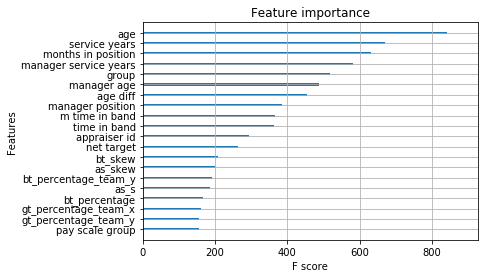

In [145]:
xgb.plot_importance(booster=lime_model, max_num_features=20, show_values=False)

In [146]:
lime_model=LogisticRegression(C=100, penalty='l1', random_state=1)
lime_model.fit(train_df, y_train)

lime_model_pred = lime_model.predict_proba(valid_for_interpretation)
roc_auc_score(y_score=lime_model_pred[:,1], y_true=y_valid)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.6462533601602305

In [196]:
lime_model_coeffs = pd.DataFrame({'columns': train_df.columns,
                                 'beta': lime_model.coef_.T.ravel()})
lime_model_coeffs['rank'] = lime_model_coeffs['beta'].rank(method='dense', ascending=False).astype('int')
lime_model_coeffs.sort_values('rank', ascending=True, inplace=True)
lime_model_coeffs.reset_index(drop=True, inplace=True)

In [197]:
lime_model_coeffs

,columns,beta,rank
0,ebm level of the job,0.322586,1
1,cr_percentage_team_x,0.310930,2
2,as_min,0.304760,3
3,group,0.266390,4
4,bt_percentage_team_x,0.254814,5
5,manager age,0.234963,6
6,gt_percentage_team_y,0.179876,7
7,bt_max,0.172255,8
8,as_max,0.140559,9
9,months in position,0.137823,10


In [235]:
valid_row = pd.DataFrame({'columns': valid_for_interpretation.columns,
                          'value': valid_for_interpretation.loc[1744][:]}).reset_index(drop=True)

In [236]:
lime_model_coeffs_1 = pd.merge(lime_model_coeffs, valid_row)
lime_model_coeffs_1['attribution'] = lime_model_coeffs_1['beta']*lime_model_coeffs_1['value']

In [237]:
valid_probs = pd.DataFrame({'probs': lime_model_pred[:, 1],
                           'actuals': y_valid})

In [238]:
lime_model_coeffs_1.attribution.sum()

2.319454674085863

In [430]:
# function to return interpretation across methods (specify which or All)

class model_interpret():
    
    def __init__():
        """ this module takes as input the model and train/test datasets to generate interpretations of the
        predictions generated by the model
        LIME and SHAP methods have been added as a provision currently, treeinterpreter will be added later
        """
    
    def lime_interpreter(feat_names, classnames, categindices, categnames, 
                         kw, num_feature, train, test, n):
        explainer = lime.lime_tabular.LimeTabularExplainer(training_data = train.values,
                                                   feature_names = list(feat_names),
                                                   class_names = classnames,
                                                   categorical_features=categindices, 
                                                   categorical_names=categnames, kernel_width = kw)
        xtest = test.values
        exp = explainer.explain_instance(xtest[n], model.predict_proba, num_features = num_feature)
        return exp.show_in_notebook()
    
    def shap_interpreter(model, train, test, n, method = 'tree'):
        """ specify n as the prediction/observation you want the interpretation to be returned for """
        
        if method == 'tree':
            # create our SHAP explainer
            shap_explainer = shap.TreeExplainer(model)
            # calculate the shapley values for our test set
            shap_values = shap_explainer.shap_values(test.values)
        elif method == 'kernel':
            # create our SHAP explainer
            shap_explainer = shap.KernelExplainer(model.predict_proba, shap.kmeans(train[:100], 5))
            shap_values = shap_explainer.shap_values(test.values)
            
        # load JS in order to use some of the plotting functions from the shap package in the notebook
        shap.initjs()
        
        # plot the explanation for a single prediction
        return shap.force_plot(shap_values[n, :], test.iloc[n, :])
    
    def model_interpreter(interpreter_algo, train, test, shap_method = 'tree', kw = 3, n = 0, model = None,
                          feat_names = None, classnames = None,
                          categindices = None, categnames = None, num_feature = None):
        if interpreter_algo == 'lime':
            return model_interpret.lime_interpreter(feat_names, classnames, categindices, categnames,
                                                    kw, num_feature, train, test, n)
        elif interpreter_algo == 'shap':
            return model_interpret.shap_interpreter(model, train, test, n, method = shap_method)

In [ ]:
x = model_interpret.model_interpreter(interpreter_algo='lime', model = model, train = X_train, test = X_test, feat_names = feat_names,
                                  classnames = ['not delayed', 'delayed'], categindices = categ_idx, categnames = categ_names,
                                 num_feature = 5, n=0)